In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from sklearn.metrics import balanced_accuracy_score, precision_recall_fscore_support, confusion_matrix, classification_report, cohen_kappa_score
import os
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dense, Flatten, Dropout

In [2]:
from sklearn.utils import class_weight
epochs = 20
learning_rate = 3.9e-5
# Parameters
IMG_HEIGHT = 299
IMG_WIDTH = 299
BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE
folder_path = './../../datasets/dataset1'
num_classes = 5
validation_split = 0.2
test_split = 0.2  # Proportion of the data to use for testing

# Load image file paths and their corresponding labels
image_paths = []
labels = []

class_names = sorted(os.listdir(folder_path))
class_indices = {name: i for i, name in enumerate(class_names)}

for class_name in class_names:
    class_path = os.path.join(folder_path, class_name)
    for file_name in os.listdir(class_path):
        file_path = os.path.join(class_path, file_name)
        image_paths.append(file_path)
        labels.append(class_indices[class_name])

image_paths = np.array(image_paths)
labels = np.array(labels)

# Split the data into training, validation, and test sets
train_paths, test_paths, train_labels, test_labels = train_test_split(image_paths, labels, test_size=test_split, stratify=labels, random_state=42)
train_paths, val_paths, train_labels, val_labels = train_test_split(train_paths, train_labels, test_size=validation_split, stratify=train_labels, random_state=42)

# Calculate class weights
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(train_labels), y=train_labels)
class_weights_dict = {i: class_weights[i] for i in range(num_classes)}

# Function to load and preprocess the images
def preprocess_image(image_path, label):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [IMG_HEIGHT, IMG_WIDTH])
    image = image / 255.0  # Normalize to [0,1]
    label = tf.one_hot(label, num_classes)
    return image, label

# Create TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_paths, train_labels))
train_dataset = train_dataset.map(preprocess_image, num_parallel_calls=AUTOTUNE)
train_dataset = train_dataset.shuffle(buffer_size=len(train_paths)).batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)

val_dataset = tf.data.Dataset.from_tensor_slices((val_paths, val_labels))
val_dataset = val_dataset.map(preprocess_image, num_parallel_calls=AUTOTUNE)
val_dataset = val_dataset.batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)

test_dataset = tf.data.Dataset.from_tensor_slices((test_paths, test_labels))
test_dataset = test_dataset.map(preprocess_image, num_parallel_calls=AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)

# Now train_dataset, val_dataset, and test_dataset are ready to use

def weighted_loss(y_true, y_pred):
    class_weights_tensor = tf.convert_to_tensor(list(class_weights_dict.values()), dtype=tf.float32)
    weights = tf.reduce_sum(class_weights_tensor * y_true, axis=-1)
    unweighted_loss = tf.keras.losses.categorical_crossentropy(y_true, y_pred)
    weighted_loss = unweighted_loss * weights
    return tf.reduce_mean(weighted_loss)

In [3]:
def balanced_accuracy(y_true, y_pred):
    y_true = tf.argmax(y_true, axis=1)
    y_pred = tf.argmax(y_pred, axis=1)
    return tf.py_function(
        func=lambda y_true, y_pred: balanced_accuracy_score(
            y_true.numpy(), y_pred.numpy()),
        inp=[y_true, y_pred],
        Tout=tf.float64)


def fscore(y_true, y_pred):
    y_true = tf.cast(tf.argmax(y_true, axis=1), tf.int32)
    y_pred = tf.cast(tf.argmax(y_pred, axis=1), tf.int32)

    def compute_fscore(y_true, y_pred):
        _, _, fscore, _ = precision_recall_fscore_support(
            y_true, y_pred, average='macro', zero_division=0)
        return fscore

    return tf.py_function(func=compute_fscore, inp=[y_true, y_pred], Tout=tf.float64)

# Custom Kappa Metric
def kappa_score(y_true, y_pred):
    y_true = tf.argmax(y_true, axis=1)
    y_pred = tf.argmax(y_pred, axis=1)
    kappa_score = tf.py_function(func=cohen_kappa_score, inp=[y_true, y_pred], Tout=tf.float32)
    return kappa_score

In [4]:

metrics = [
    'accuracy',
    tf.keras.metrics.AUC(),
    balanced_accuracy,
    fscore,
    kappa_score,
    tf.keras.metrics.Precision(),
    tf.keras.metrics.Recall()
]

In [5]:
import warnings
warnings.filterwarnings('ignore', message="A single label was found in y_true and y_pred.")
warnings.filterwarnings('ignore', message="y_pred contains classes not in y_true") 
warnings.filterwarnings('ignore', message="A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.") 


def accuracyGraph(history):
    train_accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    print ('train_accuracy-> ', train_accuracy)
    print ('val_accuracy-> ', val_accuracy)
    print ('train_loss-> ', train_loss)
    print ('val_loss-> ', val_loss)

    epochs_no = range(len(train_accuracy) + 1)


    # Plot accuracy
    plt.figure(figsize=(14, 7))
    plt.subplot(2, 2, 1)
    plt.plot(epochs_no, [0] + train_accuracy, 'b', label='Train Accuracy')
    plt.plot(epochs_no, [0] + val_accuracy, 'r', label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot loss
    plt.subplot(2, 2, 2)
    plt.plot(epochs_no, [0] + train_loss, 'b', label='Train Loss')
    plt.plot(epochs_no, [0] + val_loss, 'r', label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.figure(figsize=(14, 7))
    plt.subplot(2, 2, 3)
    plt.plot(epochs_no, [0] + val_accuracy, 'b')
    plt.title('Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')

    # Plot loss
    plt.subplot(2, 2, 4)
    plt.plot(epochs_no, [0] + val_loss, 'r')
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')

    plt.show()

    
def show_confusion_matrix(model):
    y_true = np.concatenate([y for x, y in test_dataset], axis=0)
    if y_true.ndim > 1 and y_true.shape[1] > 1:
        y_true = np.argmax(y_true, axis=1)

    y_pred = model.predict(test_dataset)
    y_pred_classes = np.argmax(y_pred, axis=1)

    print(classification_report(y_true, y_pred_classes, target_names=[str(i) for i in range(num_classes)], zero_division=0))

    conf_matrix = confusion_matrix(y_true, y_pred_classes)
    print(conf_matrix)

    # Plot the confusion matrix
    def plot_confusion_matrix(cm, class_names):
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.title('Confusion Matrix')
        plt.show()

    plot_confusion_matrix(conf_matrix, [str(i) for i in range(num_classes)])


In [6]:
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(IMG_WIDTH, IMG_HEIGHT, 3))
# Add custom top layers
# Add custom top layers
for layer in base_model.layers:
    layer.trainable = False
    
x = Flatten()(base_model.output)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(5, activation='softmax')(x)  # 5 classes for diabetic retinopathy
model = Model(inputs=base_model.input, outputs=output)

In [7]:
# # Compile the model with the custom loss function
# model.compile(optimizer=Adam(learning_rate=learning_rate), loss="categorical_crossentropy", metrics=metrics)
# print(model.summary())


# # Train the model
# history = model.fit(
#     train_dataset,
#     validation_data=val_dataset,
#     epochs=epochs,
#     batch_size=BATCH_SIZE
# )

In [8]:
# accuracyGraph(history)

In [9]:
# show_confusion_matrix(model)

In [10]:
# _metrices = model.evaluate(test_dataset)
# # _metrices = model.evaluate(test_generator, steps=test_generator.samples // batch_size)

# print("Test Metrices", _metrices)

In [11]:


x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = tf.keras.layers.Dropout(0.1)(x)
# x = tf.keras.layers.Dense(256, activation='relu')(x)
# x = tf.keras.layers.Dropout(0.1)(x)
# x = tf.keras.layers.Dense(256, activation='relu')(x)
# x = tf.keras.layers.Dropout(0.1)(x)
predictions = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Fine-tuning: Unfreeze some layers of the base model
for layer in base_model.layers[:249]:   
    layer.trainable = False
for layer in base_model.layers[249:]:
    layer.trainable = True


# Recompile the model with a lower learning rate
# model.compile(optimizer=Adam(lr=0.00001), loss=loss_fn, metrics=['accuracy'])
model.compile(optimizer=Adam(lr=learning_rate), loss=weighted_loss, metrics=metrics)

# Continue training (fine-tuning)
# Train the model
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=epochs,
    batch_size=BATCH_SIZE
)

c:\Users\Computing\anaconda3\envs\AML\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/20
703/703 [==============================] - 368s 122ms/step - loss: 1.3554 - accuracy: 0.3434 - auc: 0.7306 - balanced_accuracy: 0.3533 - fscore: 0.2147 - kappa_score: 0.0882 - precision: 0.4154 - recall: 0.0601 - val_loss: 1.2190 - val_accuracy: 0.4484 - val_auc: 0.8247 - val_balanced_accuracy: 0.4239 - val_fscore: 0.2780 - val_kappa_score: 0.1280 - val_precision: 0.5364 - val_recall: 0.1715
Epoch 2/20
703/703 [==============================] - 298s 174ms/step - loss: 1.0619 - accuracy: 0.4346 - auc: 0.8015 - balanced_accuracy: 0.4877 - fscore: 0.3134 - kappa_score: 0.1672 - precision: 0.5128 - recall: 0.1766 - val_loss: 1.1425 - val_accuracy: 0.4395 - val_auc: 0.8029 - val_balanced_accuracy: 0.4645 - val_fscore: 0.2974 - val_kappa_score: 0.1571 - val_precision: 0.5116 - val_recall: 0.1808
Epoch 3/20
703/703 [==============================] - 307s 180ms/step - loss: 0.7762 - accuracy: 0.5117 - auc: 0.8508 - balanced_accuracy: 0.6089 - fscore: 0.4177 - kappa_score: 0.2471 - p

train_accuracy->  [0.3433718979358673, 0.4346085488796234, 0.5116992592811584, 0.5896352529525757, 0.7175266742706299, 0.8186832666397095, 0.8832740187644958, 0.8931049704551697, 0.9264234900474548, 0.9153914451599121, 0.9530693888664246, 0.9511565566062927, 0.9423932433128357, 0.9571619033813477, 0.9422153234481812, 0.9600533843040466, 0.9608541131019592, 0.9772241711616516, 0.9620551466941833, 0.9650355577468872]
val_accuracy->  [0.4483985900878906, 0.4395017921924591, 0.5290035605430603, 0.4854092597961426, 0.6741992831230164, 0.6478647589683533, 0.654448390007019, 0.6435943245887756, 0.6313167214393616, 0.6094306111335754, 0.6647686958312988, 0.6279359459877014, 0.6779359579086304, 0.6491103172302246, 0.676690399646759, 0.6530249118804932, 0.6747331023216248, 0.7215302586555481, 0.6523131728172302, 0.653380811214447]
train_loss->  [1.3554133176803589, 1.061900019645691, 0.7762094140052795, 0.5665099620819092, 0.35548287630081177, 0.221479594707489, 0.14280249178409576, 0.1403849273

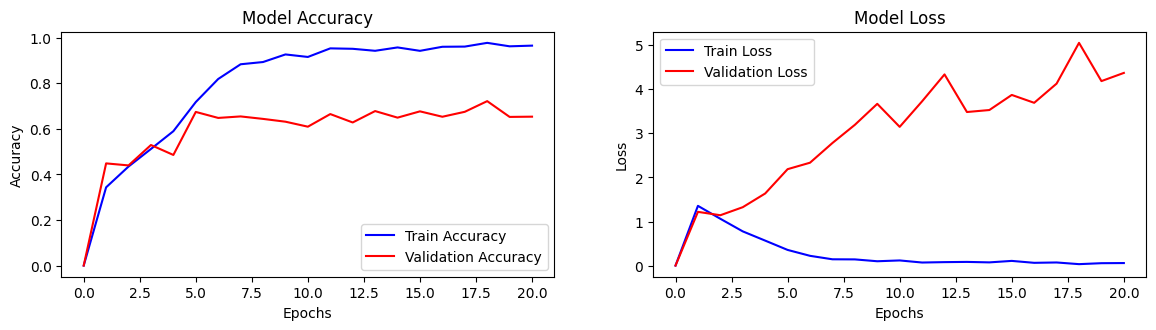

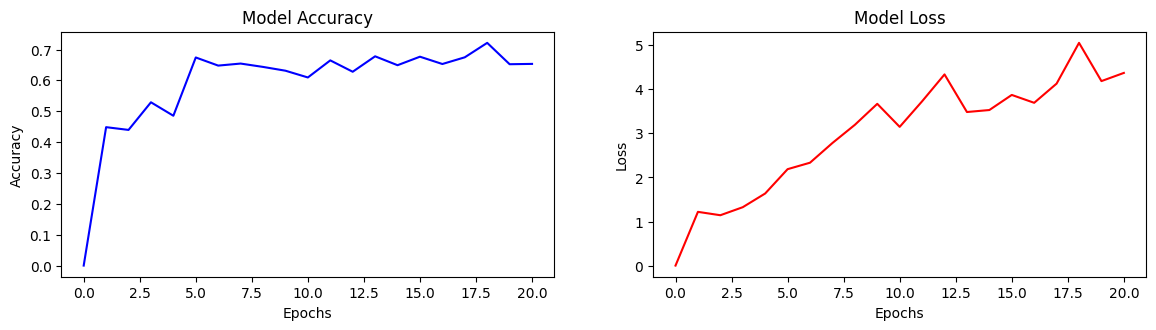

In [12]:
accuracyGraph(history)

220/220 [==============================] - 17s 73ms/step
              precision    recall  f1-score   support

           0       0.83      0.77      0.80      5162
           1       0.12      0.04      0.06       489
           2       0.28      0.47      0.35      1058
           3       0.34      0.29      0.31       175
           4       0.41      0.49      0.45       142

    accuracy                           0.65      7026
   macro avg       0.40      0.41      0.39      7026
weighted avg       0.68      0.65      0.66      7026

[[3955  122 1015   24   46]
 [ 327   20  140    2    0]
 [ 439   22  494   59   44]
 [  25    2   88   51    9]
 [  17    0   40   15   70]]


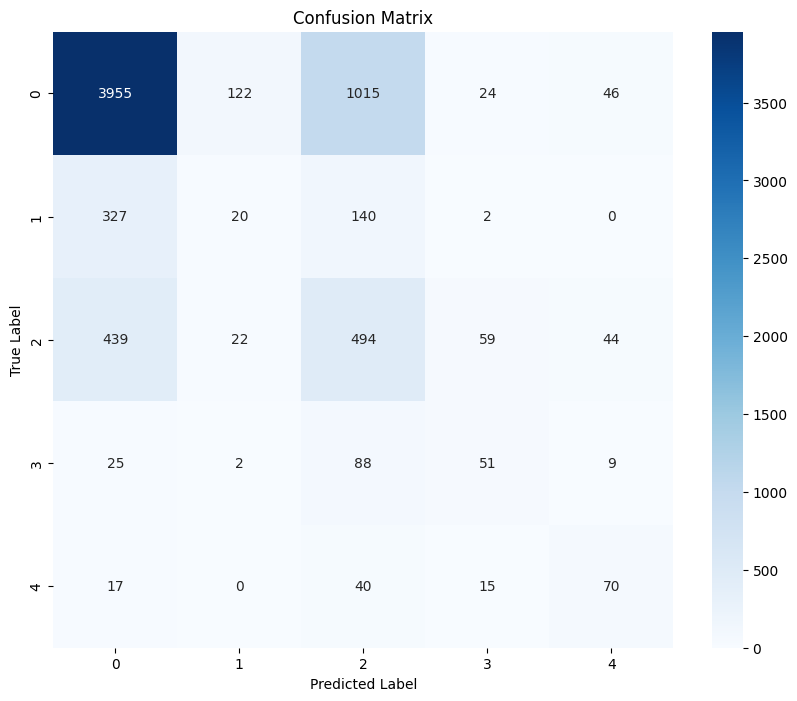

In [13]:
show_confusion_matrix(model)

In [14]:
_metrices = model.evaluate(test_dataset)
# _metrices = model.evaluate(test_generator, steps=test_generator.samples // batch_size)

print("Test Metrices", _metrices)

220/220 [==============================] - 18s 80ms/step - loss: 4.5938 - accuracy: 0.6533 - auc: 0.8632 - balanced_accuracy: 0.4366 - fscore: 0.3589 - kappa_score: 0.2428 - precision: 0.6552 - recall: 0.6497
Test Metrices [4.593757629394531, 0.6532877683639526, 0.8632166981697083, 0.4366457164287567, 0.35893723368644714, 0.24283574521541595, 0.6552318334579468, 0.6497295498847961]
